In [1]:
import os
from itertools import product

import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torch
from torch import nn

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

from convolutional_ar.reshape import ar_reshape
from convolutional_ar.interp import interpolate_circle
from convolutional_ar.nn import train_ar, AR
from convolutional_ar.psd import ar_to_psd

## Rotational Invariant Simultaneous Autoregressive Model

Circles of AR coefficients are solved. See:

Jianchang Mao, Anil K. Jain, Texture classification and segmentation using multiresolution simultaneous autoregressive models,
Pattern Recognition, Volume 25, Issue 2, 1992, Pages 173-188, ISSN 0031-3203, https://doi.org/10.1016/0031-3203(92)90099-5.

This model is extended to convolution by sliding circles over images, and solving for AR weights.

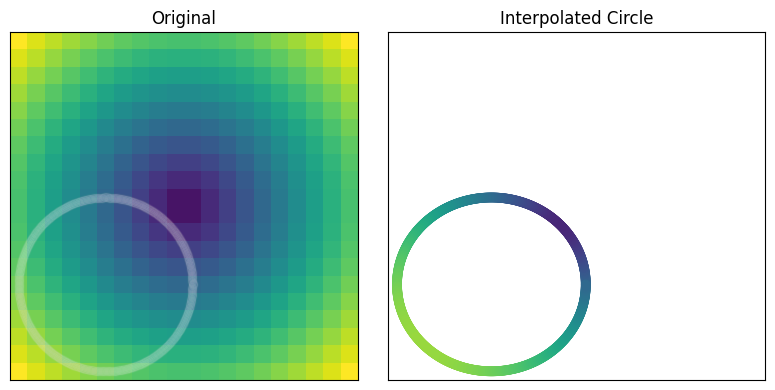

In [2]:
# Example demonstration of interpolating along a circle
#   Checks to confirm interpolation is correct on a simulated input
x_axis = np.linspace(-1, 1, 20)[:, None]
y_axis = np.linspace(-1, 1, 20)[None, :]

inner = np.array([0, 0, 0])[None, None, :]
outer = np.array([1, 1, 1])[None, None, :]

arr = np.sqrt(x_axis ** 2 + y_axis ** 2)
arr /= arr.max()
arr = arr[:, :, None]
arr = (arr * outer + (1 - arr) * inner)[:, :, 0]

# Interpolate
img = arr
n_points = 1000
radius = 5
center = (5, 5)
x2, y2, interp_vals = interpolate_circle(img, n_points, radius, center)

# Plot
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

ax0im = axes[0].imshow(img, origin='lower')
ax0im.set_clim(0, 1)
axes[0].scatter(x2, y2, color='white', alpha=.025)

ax1im = axes[1].scatter(x2, y2, c=interp_vals)
ax1im.set_clim(0, 1)

axes[0].set_title('Original')
axes[1].set_title('Interpolated Circle')

axes[1].set_xlim(*axes[0].get_xlim())
axes[1].set_ylim(*axes[0].get_ylim())

axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])

plt.tight_layout();

## Circular Grid

An AR model is solved across each circle below. Moving the circle across the image protects against translations in the image. The circle protects against rotations. Scale invariance is not protect against here, e.g. zooming in or out will cause issues. This could involve learning optimal circle radii per image. After the AR coefficients are learned, they may be used to compute power spectral density.

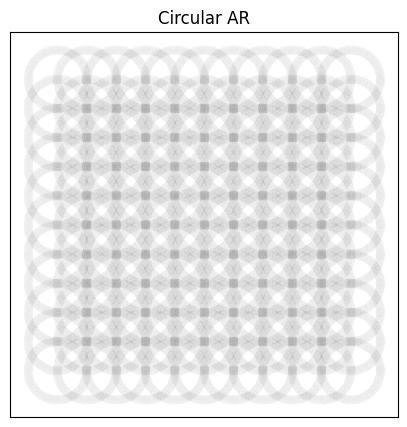

In [5]:
plt.figure(figsize=(5, 5))
img = np.ones((576, 576))
radius = 50
n_points = 100

for ix in np.arange(radius+1, len(img), 50):
    for iy in np.arange(radius+1, len(img[0]), 50):
        center = (ix, iy)
        x2, y2, _ = interpolate_circle(img, n_points, radius, center)
        plt.scatter(x2, y2, color='k', alpha=.01)

plt.xticks([])
plt.yticks([])

plt.title('Circular AR');

### Textures

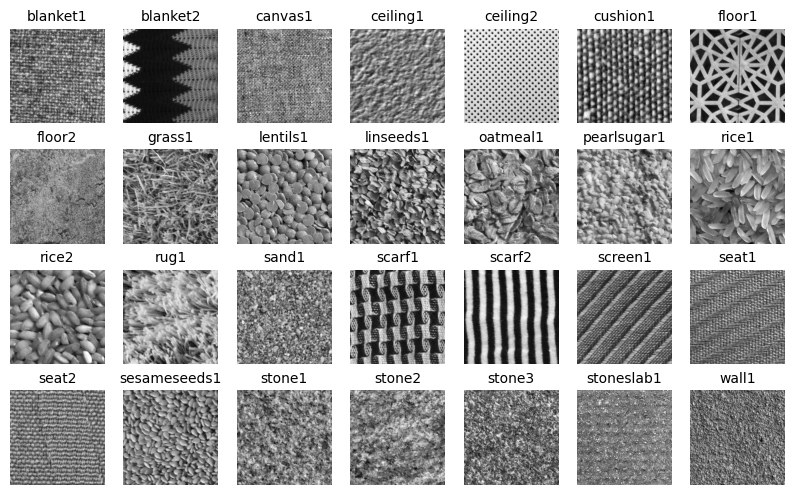

In [2]:
# Load
base_dir = "datasets/kylberg"

f = os.listdir(base_dir)
f.sort()
f = [i for i in f if i.endswith('.png')]

classes = [i.split('-')[0].split('.')[0] for i in f]
classes = np.unique(classes)

y = np.arange(len(classes))

classes = {c:int(i) for c, i in zip(classes, y)}
n_classes = len(classes)

# Data and labels
X = torch.zeros(len(f), 576, 576)
y = torch.zeros(len(f))

for i in range(len(f)):
    X[i] = torchvision.io.read_image(f"{base_dir}/{f[i]}")[0]
    y[i] = classes[f[i].split('-')[0].split('.')[0]]

# Plot examples
fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(10, 6))
axes = axes.flatten()

for c in classes.keys():
    i = classes[c]
    axes[i].imshow(X[np.where(y == i)[0][0]], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(c, size=10)

### Solve AR

In [27]:
# Interpolation parameters
radius = 50
n_points = 1000
spacing = 50

ix = np.arange(radius+1, len(X[0][0]), spacing)
iy = np.arange(radius+1, len(X[0]), spacing)

grid = np.array(list(product(ix, iy)))

# Learning parameters
lr = 1e-4
n_epochs = 100
batch_size = 200
n_retries = 5

# Training: took 20 ish hours to run on an M1
ar_order = 20
ar_coefs = np.zeros((len(X), ar_order))

for ix, x in enumerate(X):

    break # prevent accidently rerunning and overwriting existing

    # Normalize pixel values
    x = (x-x.mean()) / x.std()

    # Learn AR parameters
    for ir in range(n_retries):

        # AR grid
        for ig, g in enumerate(grid):
            
            center = (g[0], g[1])
            
            if ir == 0:
                # No added noise
                _, _, X_interp = interpolate_circle(x.numpy(), n_points, radius, center)
            else:
                # Sometimes interpolate_circle produces nans (needs to be looked into)
                #     adding a tiny amount of noise usually fixes
                 _, _, X_interp = interpolate_circle(x.numpy() + np.random.rand(*x.shape)/100000,
                                                     n_points, radius, center)

        # Reshape
        x_ar, y_ar = ar_reshape(X_interp, ar_order)

        # Fit
        ar_coefs[ix] = train_ar(x_ar, y_ar, loss_fn, opt, lr, n_epochs, batch_size,
                                progress=tqdm, save_dir="models", save_index=ix)


        # Retry is weights contain nan or if loss is not small
        loss = (((x_ar @ ar_coefs[ix]) - y_ar)**2).mean()
        if np.any(np.isnan(ar_coefs[ix])) or loss > 0.01:
            continue
        else:
            break

### PSD

In [3]:
# Reload torch models
fmodels = os.listdir("models")
fmodels.sort()

X_ar = []
y_ar = []

for i, f in enumerate(fmodels):
    m = torch.load("models/" + f)
    ar_coefs = m.w.detach().numpy()
    
    if np.isnan(ar_coefs[0]):
        continue

    freqs, powers = ar_to_psd(ar_coefs, nfft=500)
    
    X_ar.append(powers)
    y_ar.append(int(y[i]))

X_ar = np.log10(np.array(X_ar))
#X_ar = np.array(X_ar)
y_ar = np.array(y_ar)

print(X_ar.shape, y_ar.shape)

(4480, 249) (4480,)


## Modeling

SVM to predict class.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_ar, y_ar, train_size=0.8)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

svc = SVC(C=1e2, probability=True)
svc.fit(X_train, y_train)

print('Accuracy: ', (svc.predict(X_test) == y_test).sum() / len(y_test))

Accuracy:  0.9162946428571429


### One-vs-Rest ROC Curves

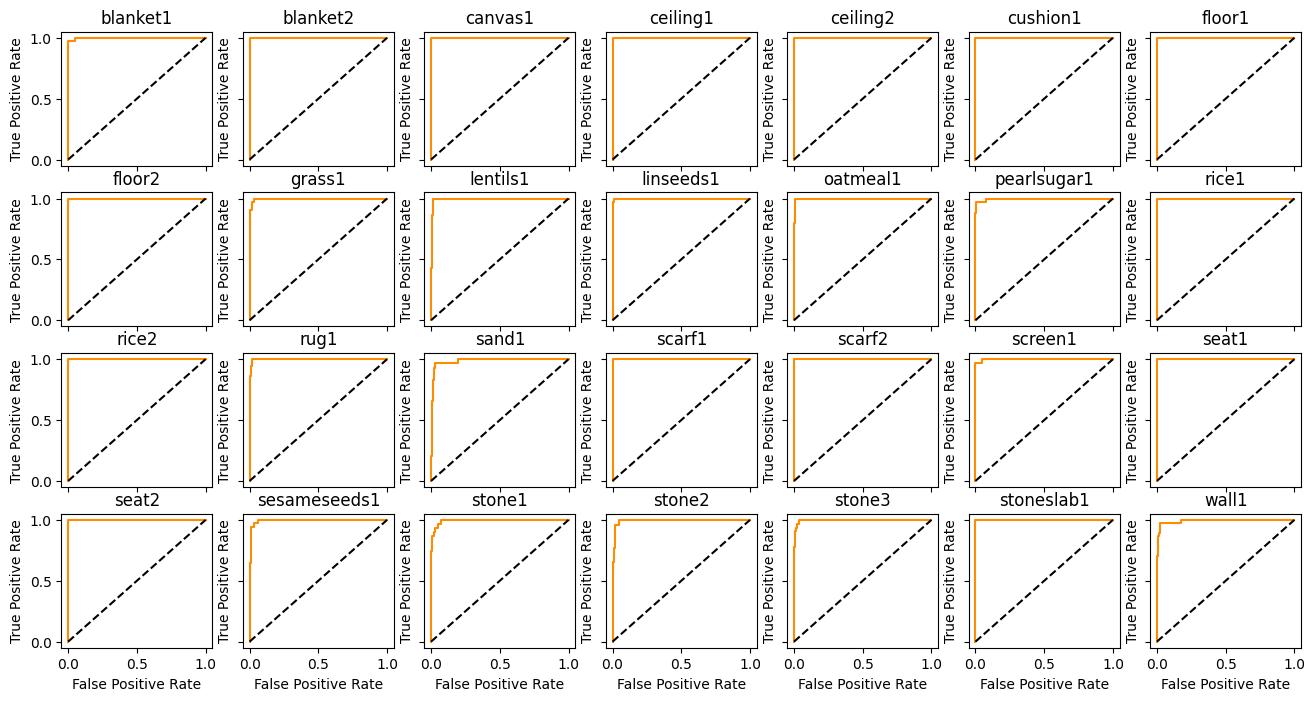

In [6]:
# Plot examples
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)

y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

y_score = svc.predict_proba(X_test)


fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(16, 8), sharex=True, sharey=True)
axes = axes.flatten()

for c in classes.keys():
    i = classes[c]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, i],
        y_score[:, i],
        name=f"{c} vs the rest",
        color="darkorange",
        plot_chance_level=True,
        ax=axes[i]
    )
    axes[i].set_ylabel("True Positive Rate")
    if i > 20:
        axes[i].set_xlabel("False Positive Rate") 
    else:
        axes[i].set_xlabel("")
    axes[i].get_legend().remove()
    axes[i].set_title(f"{c}")

### Cross-Validation

In [8]:
performance = {
    'acc': np.zeros(10),
    'roc_auc': np.zeros(10)
}

kf = StratifiedKFold(n_splits=10)

for i, (train, test) in enumerate(kf.split(X_ar, y_ar)):
    # Split
    X_train, y_train = X_ar[train],  y_ar[train]
    X_test, y_test = X_ar[test],  y_ar[test]

    # Scale
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)

    # Fit
    svc = SVC(C=1e2, probability=True)
    svc.fit(X_train, y_train)

    performance['acc'][i] = (svc.predict(X_test) == y_test).sum() / len(y_test)
    performance['roc_auc'][i] = roc_auc_score(y_test, svc.predict_proba(X_test), multi_class='ovr')

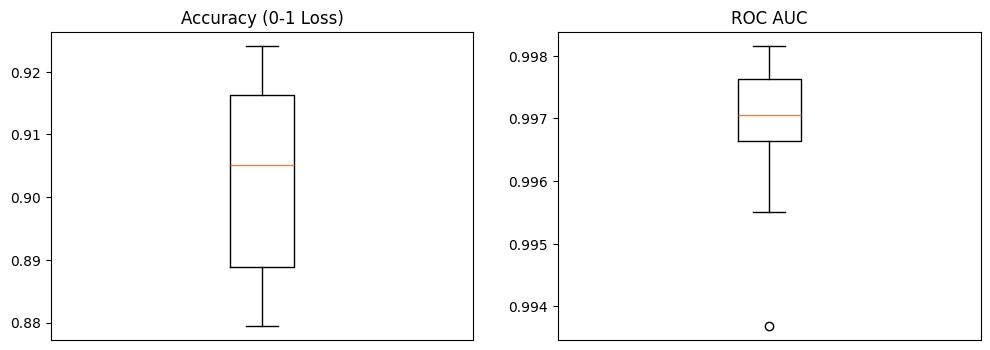

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

axes[0].boxplot(performance['acc'])
axes[1].boxplot(performance['roc_auc'])

axes[0].set_title('Accuracy (0-1 Loss)')
axes[1].set_title('ROC AUC')
axes[0].set_xticks([])
axes[1].set_xticks([]);